In [1]:
from PIL import Image, ImageChops, ImageEnhance
import sys, os.path
import matplotlib.pyplot as plt

from torchvision import transforms
from fastai.vision import *
from fastai.core import *

from facenet_pytorch import MTCNN

import cv2

In [233]:
MTCNN??

In [263]:
class DetectionPipeline:
    def __init__(self, detector=None, nf=None, bs=60, fsz=None):
        if detector is None: detector = self.default_detector()
        self.detector = detector
        self.nf, self.bs, self.fsz = nf, bs, fsz

    def default_detector(self):
        device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        return MTCNN(device=device, image_size=512, margin=100,
                     post_process=False, select_largest=False, keep_all=True)

    def get_sample(self, vlen, n_frames):
        if n_frames is None: return np.arange(0, vlen)
        else: return np.linspace(0, vlen - 1, n_frames).astype(int)

    def resize(self, frame, size):
        return frame.resize([int(d * size) for d in frame.size])

    def get_savepaths(self, filename, idxs, label=None, save_dir=None):
        if isinstance(filename, str): filename = Path(filename)
        if save_dir is None: save_dir = Path('./')
        if label is None: save_paths = [save_dir/f'{filename.stem}_{i:03d}.png' for i in idxs]
        else: save_paths = [save_dir/f'{filename.stem}_{i:03d}_{label}.png' for i in idxs]
        return [str(o) for o in save_paths]

    def equalize(self, frame):
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        frame[:,:,0] = clahe.apply(frame[:,:,0])
        return cv2.cvtColor(frame, cv2.COLOR_YCrCb2RGB)

    def __call__(self, filename, equalize=False, label=None, save_dir=None):
        assert Path(filename).exists()
        vcap = cv2.VideoCapture(str(filename))
        vlen = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        sample = self.get_sample(vlen, self.nf)
        iframes, faces, probs = [], [], []
        ib, fb = [], []
        for i in progress_bar(range(vlen)):
            _ = vcap.grab()
            if i in sample:
                success, f = vcap.retrieve()
                if not success: continue
                if equalize: f = self.equalize(f)
                else: f = cv2.cvtColor(f, cv2.COLOR_BGR2RGB)
                f = PIL.Image.fromarray(f)
                if self.fsz is not None: f = self.resize(f, self.fsz)
                ib.append(i); fb.append(f)
                if len(fb) % self.bs == 0 or i == sample[-1]:
                    savepaths = self.get_savepaths(filename, ib, label, save_dir) if save_dir else None
                    faceb, probb = self.detector(fb, return_prob=True, save_path=savepaths)
                    iframes.extend(ib); faces.extend(faceb); probs.extend(probb)
                    ib, fb = [], []
        vcap.release()
        return iframes, faces, probs

In [264]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [265]:
detector = MTCNN(device=device, post_process=False)

In [266]:
facepipe = DetectionPipeline(nf=15)

“Error level analysis (ELA) works by intentionally resaving the image at a known error rate, such as 95%, and then computing the difference between the images. If there is virtually no change, then the cell has reached its local minima for error at that quality level. However, if there is a large amount of change, then the pixels are not at their local minima and are effectively original.” 

In [267]:
def ela(fn):
    iframes, faces, probs = facepipe(fn)
    
    
    #im = PIL.Image.open(fn)
    quality = 95
    im = transforms.ToPILImage()(faces[3].squeeze()/255.).convert("RGB")
    outputIoStream = BytesIO()
    im.save(outputIoStream, "JPEG", quality=quality, optimice=True)
    outputIoStream.seek(0)
    resaved_im = PIL.Image.open(outputIoStream)

    ela_im = ImageChops.difference(im, resaved_im)
    extrema = ela_im.getextrema()
    max_diff = max([ex[1] for ex in extrema])
    scale = 255.0/max_diff
    
    ela_im = ImageEnhance.Brightness(ela_im).enhance(scale)

    print(f"Maximum difference was {max_diff}")
    
    title = 'Original Image/Compressed Image/Result'
    
    fig, axs = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True, gridspec_kw={'wspace': 0})
    fig.suptitle(title)
    axs[0].imshow(im)
    axs[1].imshow(resaved_im)
    axs[2].imshow(ela_im)

In [268]:
fn = '../data/train_sample_videos/acqfdwsrhi.mp4'

Maximum difference was 5


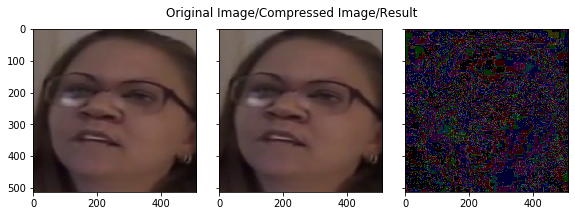

In [269]:
ela(fn)

In [270]:
fn = '../data/train_sample_videos/abarnvbtwb.mp4'

Maximum difference was 10


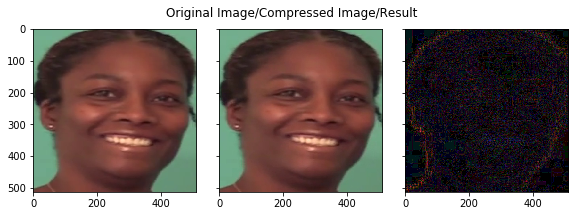

In [271]:
ela(fn)

In [282]:
def noise_analysis(fn, ksize=7):
    iframes, faces, probs = facepipe(fn)
    
    im = transforms.ToPILImage()(faces[3].squeeze()/255.).convert("RGB")

    filtered_im = im.filter(PIL.ImageFilter.MedianFilter(size=ksize))

    buffer1    = np.asarray(im)
    buffer2    = np.asarray(filtered_im)
    buffer3    = buffer1 - buffer2

    na_im     = PIL.Image.fromarray(buffer3)
    
    title = 'Original Image/Filtered Image/Result'


    fig, axs = plt.subplots(1,3, figsize=(10,3), sharex=True, sharey=True, gridspec_kw={'wspace': 0})
    fig.suptitle(title)
    axs[0].imshow(im)
    axs[1].imshow(filtered_im)
    axs[2].imshow(na_im)

In [283]:
fn = '../data/train_sample_videos/acqfdwsrhi.mp4'

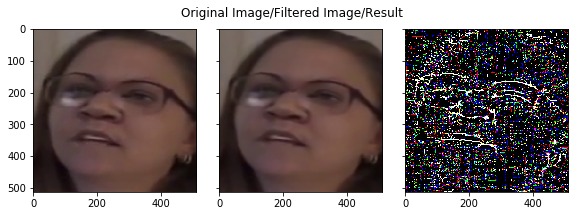

In [284]:
noise_analysis(fn)

In [285]:
fn = '../data/train_sample_videos/abarnvbtwb.mp4'

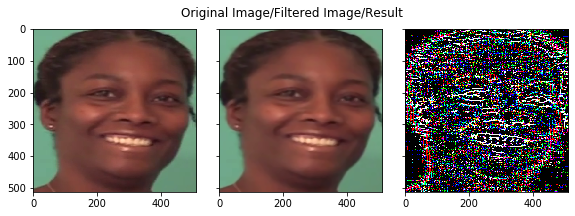

In [286]:
noise_analysis(fn)